# Evaluating binary classifiers through ROC curves

## 1. Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.style.use("ggplot")

In [2]:
bunch = load_breast_cancer()
X = pd.DataFrame(bunch["data"], columns = bunch["feature_names"])
y = np.logical_xor(bunch["target"], 
                   np.random.RandomState(seed = 405).binomial(1, 0.8, X.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [4]:
#print(bunch["DESCR"])

## 2. Naive evaluation

Let's fit logistic and random forest classifiers.

In [5]:
models = {"logistic" : LogisticRegression(solver = "liblinear"),
          "rf" : RandomForestClassifier()}
y_hat_test = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_hat_test[model_name] = model.predict(X_test)

We want to evaluate the performance of models for two purposes
1. Model validation (absolute performance of model)
2. Model selection (relative performance of model)

In [6]:
pd.DataFrame(confusion_matrix(y_test, y_hat_test["rf"]),
             columns = ["D=0", "D=1"],
             index = ["R=0", "R=1"]
            )

,D=0,D=1
R=0,90,16
R=1,24,58


In [7]:
pd.DataFrame(confusion_matrix(y_test, y_hat_test["logistic"]),
             columns = ["D=0", "D=1"],
             index = ["R=0", "R=1"]
            )

,D=0,D=1
R=0,93,13
R=1,26,56


## 3. Thresholds

In [8]:
models["rf"].predict(X_test)

array([False,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True, False,  True, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False,  True,  True, False, False,  True,  True,
       False,  True,  True, False, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True, False,  True,  True, False, False, False,  True,
        True, False,  True, False,  True,  True, False,  True, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False,

In [11]:
models["rf"].predict_proba(X_test)
pred_probs = models["rf"].predict_proba(X_test)[:,1]
pred_probs.round(3)

array([0.09, 0.87, 0.94, 0.16, 0.1 , 0.69, 0.96, 0.87, 0.66, 0.26, 0.24,
       0.94, 0.22, 0.8 , 0.42, 0.59, 0.2 , 0.29, 0.45, 0.79, 0.39, 0.1 ,
       0.97, 0.32, 0.1 , 0.28, 0.26, 0.26, 0.02, 0.87, 0.15, 0.26, 0.38,
       0.41, 0.26, 0.14, 0.55, 0.32, 0.93, 0.45, 0.07, 0.86, 0.06, 0.18,
       0.44, 0.32, 0.24, 0.33, 0.16, 0.21, 0.7 , 0.9 , 0.3 , 0.48, 0.17,
       0.25, 0.16, 0.76, 0.76, 0.2 , 0.04, 0.92, 0.84, 0.41, 0.18, 0.31,
       0.94, 0.7 , 0.12, 0.11, 0.73, 0.98, 0.2 , 0.99, 0.55, 0.24, 0.29,
       0.59, 0.28, 0.23, 0.92, 0.26, 0.53, 0.85, 0.67, 0.82, 0.67, 0.79,
       0.31, 0.21, 0.1 , 0.3 , 0.47, 0.24, 0.16, 0.18, 0.55, 0.77, 0.1 ,
       0.92, 0.84, 0.44, 0.93, 0.88, 0.16, 0.08, 0.19, 0.8 , 0.54, 0.27,
       0.87, 0.09, 0.55, 0.72, 0.39, 0.7 , 0.3 , 0.23, 0.24, 0.85, 0.6 ,
       0.05, 0.09, 0.85, 0.11, 0.76, 0.97, 0.17, 0.28, 0.91, 0.81, 0.75,
       0.37, 0.08, 0.26, 0.91, 0.49, 0.17, 0.71, 0.75, 0.08, 0.78, 0.19,
       0.41, 0.93, 0.16, 0.86, 0.66, 0.57, 0.32, 0.

Predicted class is obtained by thresholding predicted (class 1) probability at 0.5

In [13]:
np.all((models["rf"].predict_proba(X_test)[:,1] > 0.5) == models["rf"].predict(X_test))

True

In [14]:
threshold = 0.25
y_preds = (models["rf"].predict_proba(X_test)[:,1] > threshold).astype(int)
pd.DataFrame(confusion_matrix(y_test, y_preds),
             columns = ["D=0", "D=1"],
             index = ["R=0", "R=1"]
            )

,D=0,D=1
R=0,47,59
R=1,15,67


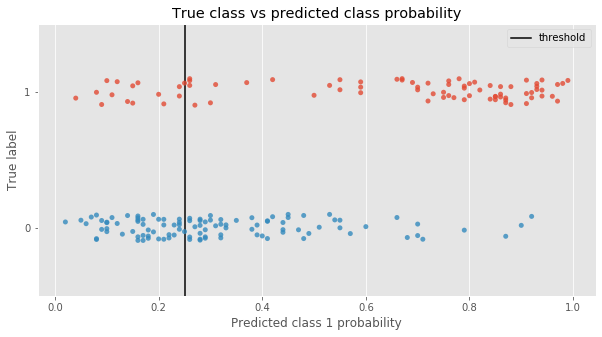

In [17]:
plt.figure(figsize = (10,5))
sns.stripplot(pred_probs, y_test, alpha = 0.8, order = [1,0], orient = "h")
plt.axvline(threshold, c = "k", label = "threshold")
plt.xlabel("Predicted class 1 probability")
plt.ylabel("True label")
plt.title("True class vs predicted class probability")
plt.legend()
plt.show()

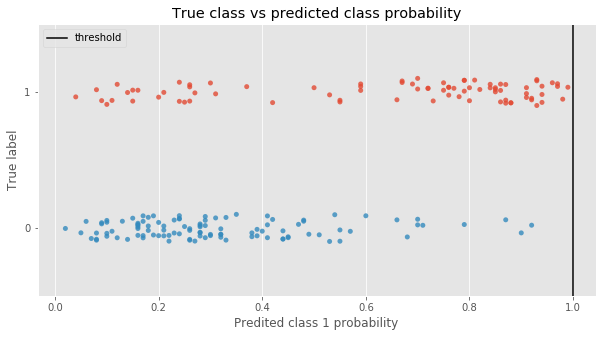

,D=0,D=1
R=0,106,0
R=1,82,0


In [31]:
threshold = 1
y_preds = (models["rf"].predict_proba(X_test)[:,1] > threshold).astype(int)

plt.figure(figsize = (10,5))
sns.stripplot(pred_probs, y_test, alpha = 0.8, order = [1,0], orient = "h")
plt.axvline(threshold, c = "k", label = "threshold")
plt.xlabel("Predited class 1 probability")
plt.ylabel("True label")
plt.title("True class vs predicted class probability")
plt.legend()
plt.show()

pd.DataFrame(confusion_matrix(y_test, y_preds),
             columns = ["D=0", "D=1"],
             index = ["R=0", "R=1"]
            )

## 4. ROC curve

In [32]:
def get_tpr_fpr(y_test, pred_probs, threshold):
    P = y_test.sum()
    N = (1-y_test).sum()
    preds = (pred_probs >= threshold).astype(int)
    confusion_mat = confusion_matrix(y_test, preds)
    TP = confusion_mat[1,1]
    FP = confusion_mat[0,1]
    TPR = TP / P
    FPR = FP / N
    
    return TPR, FPR

In [33]:
results_df = pd.DataFrame(columns = ["threshold", "TPR", "FPR"])
thresholds = [0, 0.2, 0.4, 0.6, 0.8, 1]
for threshold in thresholds:
    TPR, FPR = get_tpr_fpr(y_test, pred_probs, threshold)
    results_df = results_df.append({"threshold" : threshold,
                                    "TPR" : TPR,
                                    "FPR" : FPR}, 
                                   ignore_index = True)
results_df

,threshold,TPR,FPR
0,0.0,1.000000,1.000000
1,0.2,0.878049,0.688679
2,0.4,0.731707,0.283019
3,0.6,0.634146,0.094340
4,0.8,0.402439,0.028302
5,1.0,0.000000,0.000000


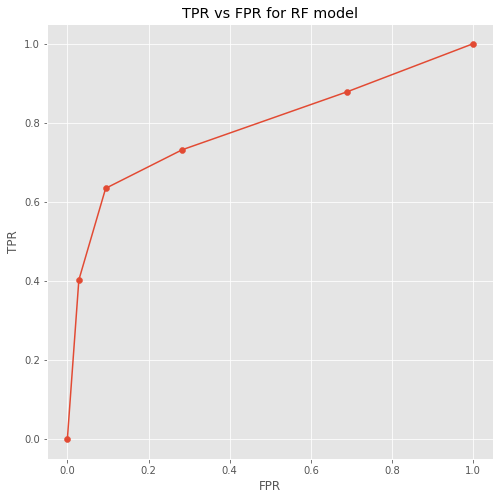

In [35]:
plt.figure(figsize = (8,8))
plt.scatter(results_df["FPR"], results_df["TPR"])
plt.plot(results_df["FPR"], results_df["TPR"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("TPR vs FPR for RF model")
plt.show()

### 4.2. Sklearn

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

In [38]:
fpr, tpr, _ = roc_curve(y_test, pred_probs)

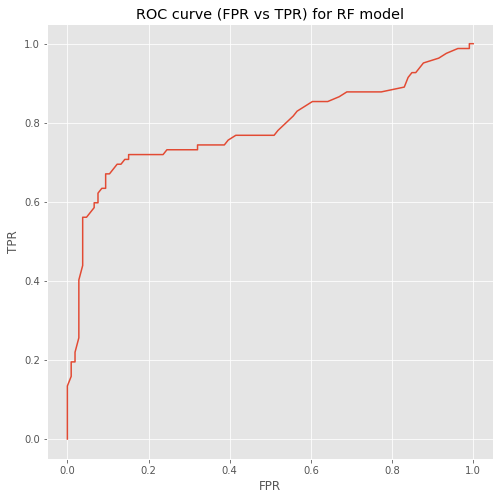

In [39]:
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr)
#plt.scatter(results_df["FPR"], results_df["TPR"])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("ROC curve (FPR vs TPR) for RF model")
plt.show()

In [40]:
roc_auc_score(y_test, models["rf"].predict_proba(X_test)[:,1])

0.7861826967326276

In [41]:
roc_auc_score(y_test, models["logistic"].predict_proba(X_test)[:,1])

0.8312241141279337

## 5. Precision-recall curve

In [42]:
from sklearn.metrics import precision_recall_curve, auc

In [43]:
prec, tpr, _ = precision_recall_curve(y_test, models["logistic"].predict_proba(X_test)[:,1])

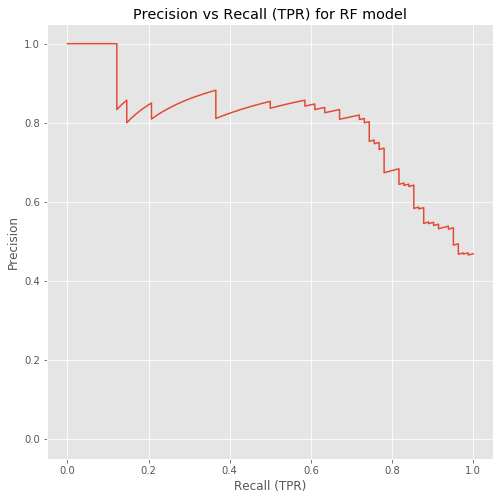

In [44]:
plt.figure(figsize = (8,8))
plt.plot(tpr, prec)
#plt.scatter(results_df["FPR"], results_df["TPR"])
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Precision vs Recall (TPR) for RF model")
plt.show()